## MMM experiments
Sharing this notebook to demonstrate how easy it is to build on top of `pymc-marketing` and an approach for evaluating and comparing model variants.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
import numpy as np
import numpy.typing as npt
import itertools

import os
import sys
import psutil
import yaml
import json

from pymc_marketing.mmm.base import MMM
from pymc_marketing.mmm.preprocessing import MaxAbsScaleChannels, MaxAbsScaleTarget, StandardizeControls, preprocessing_method_X
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.utils import generate_fourier_modes
from pymc_marketing.mmm.validating import ValidateControlColumns
from typing import Union, Dict, List, Optional, Any
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler

sys.path.append('..')
from src.data import build_regression_data_from_benchmark_org

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

RANDOM_SEED = 676
rng = np.random.default_rng(RANDOM_SEED)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

#### Specify the model

Principles behind some of the modeling choices:
- `MaxAbsScaler` is used for both target and channel variables. This ensures the 0 spend = 0 scaled spend, which allows us to implement the assumption the channel contributions are positive.
- `HalfNormal` distributions are used for channel coefficients to enforce positivity
- `StudentT` distribution is an option for likelihood as it is more robust to outlier values.

In [2]:
class MyStandardizeControls:
    """
    This modifies the built-in class to handle no control_columns
    """
    control_columns: Optional[List[str]]

    @preprocessing_method_X
    def standardize_control_data(self, data: pd.DataFrame) -> pd.DataFrame:
        if self.control_columns is None:
            return data
        data_cp = data.copy()
        control_data: pd.DataFrame = data_cp[self.control_columns]
        transformers = [("scaler", StandardScaler())]
        pipeline: Pipeline = Pipeline(steps=transformers)
        self.control_transformer: Pipeline = pipeline.fit(X=control_data.to_numpy())
        data_cp[self.control_columns] = self.control_transformer.transform(
            control_data.to_numpy()
        )
        return data_cp


class MyMMM(
    MMM, MaxAbsScaleTarget, MaxAbsScaleChannels, MyStandardizeControls, ValidateControlColumns
):
    _model_type = "MyMMM"

    def __init__(
        self,
        date_column: str,
        channel_columns: List[str],
        control_columns: Optional[List[str]] = None,
        yearly_seasonality: Optional[int] = None,
        channel_transforms: str = 'adstock_saturated',
        adstock_max_lag: int = 4,
        data_likelihood: str = 'normal',
        sampler_config: Optional[Dict] = None
    ) -> None:
        self.control_columns = control_columns
        self.yearly_seasonality = yearly_seasonality
        self.adstock_max_lag = adstock_max_lag
        self.data_likelihood = data_likelihood
        self.channel_transforms = channel_transforms

        # The MMM base class uses mixins to handle data scaling and validation
        super().__init__(
            date_column=date_column,
            channel_columns=channel_columns,
            model_config=None,
            sampler_config=sampler_config,
            adstock_max_lag=adstock_max_lag,
        )

    @property
    def default_sampler_config(self) -> Dict:
        sampler_config: Dict = {
            "draws": 4000,
            "chains": 4
        }
        return sampler_config
    
    @property
    def default_model_config(self) -> Dict:
        model_config: Dict = {
            "intercept": {"mu": 0, "sigma": 2},
            "beta_channel": {"sigma": 2, "dims": "channel"},
            "alpha": {"alpha": 1, "beta": 3, "dims": "channel"},
            "lam": {"alpha": 3, "beta": 1, "dims": "channel"},
            "sigma": {"sigma": 2},
            "nu": {"alpha": 25, "beta": 2},
            "gamma_control": {"mu": 0, "sigma": 2, "dims": "control"},
            "mu": {"dims": "date"},
            "likelihood": {"dims": "date"},
            "gamma_fourier": {"mu": 0, "b": 1, "dims": "fourier_mode"},
        }
        return model_config

    @property
    def output_var(self):
        return "y"

    def _generate_and_preprocess_model_data(
        self, X: Union[pd.DataFrame, pd.Series], y: pd.Series
    ) -> None:
        """
        Applies preprocessing to the data before fitting the model.

        Parameters
        ----------
        X : array, shape (n_obs, n_features)
        y : array, shape (n_obs,)
        """
        date_data = X[self.date_column]
        channel_data = X[self.channel_columns]

        X_data = pd.DataFrame.from_dict({self.date_column: date_data})
        X_data = pd.concat([X_data, channel_data], axis=1)
        control_data: Optional[Union[pd.DataFrame, pd.Series]] = None
        if self.control_columns is not None:
            control_data = X[self.control_columns]
            X_data = pd.concat([X_data, control_data], axis=1)
        fourier_features: Optional[pd.DataFrame] = None
        if self.yearly_seasonality is not None:
            fourier_features = self._get_fourier_models_data(X=X)
            self.fourier_columns = fourier_features.columns
            X_data = pd.concat([X_data, fourier_features], axis=1)

        self.validate("X", X_data)
        self.validate("y", y)
        self.preprocessed_data: Dict[str, Union[pd.DataFrame, pd.Series]] = {
            "X": self.preprocess("X", X_data),
            "y": self.preprocess("y", y),
        }
        self.X: pd.DataFrame = X_data
        self.y: pd.Series = y


    def _get_fourier_models_data(self, X) -> pd.DataFrame:
        """
        Generates fourier modes to model seasonality.
        https://www.pymc.io/projects/examples/en/latest/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html
        """
        if self.yearly_seasonality is None:
            raise ValueError("yearly_seasonality must be specified.")
        date_data: pd.Series = pd.to_datetime(
            arg=X[self.date_column], format="%Y-%m-%d"
        )
        periods: npt.NDArray[np.float_] = date_data.dt.dayofyear.to_numpy() / 365.25
        return generate_fourier_modes(
            periods=periods,
            n_order=self.yearly_seasonality,
        )


    def build_model(
        self,
        X: pd.DataFrame,
        y: pd.Series
    ) -> None:

        # initialise model and setup coords for labeling dims
        self.model = pm.Model()
        self.model.add_coord(
            name='date',
            values=self.preprocessed_data["X"][self.date_column],
            mutable=True  # making mutable for cross-validation
        )
        self.model.add_coord(
            name='channel',
            values=self.preprocessed_data["X"][self.channel_columns]
        )
        if self.control_columns is not None:
            self.model.add_coord(
                name='control',
                values=self.preprocessed_data["X"][self.control_columns]
            )
        if hasattr(self, "fourier_columns") and self.fourier_columns is not None:
            self.model.add_coord(
                name='fourier_mode',
                values=self.preprocessed_data["X"][self.fourier_columns]
            )

        with self.model:
            # -- data containiers
            channel_data_ = pm.MutableData(
                name="channel_data",
                value=self.preprocessed_data["X"][self.channel_columns],
                dims=("date", "channel")
            )
            target_data_ = pm.MutableData(
                name="target_data",
                value=self.preprocessed_data["y"],
                dims="date"
            )

            # -- add intercept and channel variables
            intercept = pm.Normal(
                name="intercept", 
                mu=self.model_config['intercept']['mu'],
                sigma=self.model_config['intercept']['sigma']
            )
            beta_channel = pm.HalfNormal(
                name="beta_channel",
                sigma=self.model_config['beta_channel']['sigma'],
                dims="channel"
            )

            match self.channel_transforms:
                case 'no_transforms':
                    channel_contributions = pm.Deterministic(
                        name="channel_contributions",
                        var=beta_channel * channel_data_,
                        dims=("date", "channel"),
                    )
                case 'adstock_only':
                    alpha = pm.Beta(
                        name="alpha",
                        alpha=self.model_config['alpha']['alpha'],
                        beta=self.model_config['alpha']['beta'],
                        dims="channel"
                    )
                    channel_adstock = pm.Deterministic(
                        name="channel_adstock",
                        var=geometric_adstock(x=channel_data_, alpha=alpha, l_max=self.adstock_max_lag , normalize=True, axis=0),
                        dims=("date", "channel"),
                    )
                    channel_contributions = pm.Deterministic(
                        name="channel_contributions",
                        var=beta_channel * channel_adstock,
                        dims=("date", "channel"),
                    )
                case 'adstock_saturated':
                    alpha = pm.Beta(
                        name="alpha",
                        alpha=self.model_config['alpha']['alpha'],
                        beta=self.model_config['alpha']['beta'],
                        dims="channel"
                    )
                    lam = pm.Gamma(
                        name="lam",
                        alpha=self.model_config['lam']['alpha'],
                        beta=self.model_config['lam']['beta'],
                        dims="channel"
                    )
                    channel_adstock = pm.Deterministic(
                        name="channel_adstock",
                        var=geometric_adstock(x=channel_data_, alpha=alpha, l_max=self.adstock_max_lag, normalize=True, axis=0),
                        dims=("date", "channel"),
                    )
                    channel_adstock_saturated = pm.Deterministic(
                        name="channel_adstock_saturated",
                        var=logistic_saturation(x=channel_adstock, lam=lam),
                        dims=("date", "channel"),
                    )
                    channel_contributions = pm.Deterministic(
                        name="channel_contributions",
                        var=beta_channel * channel_adstock_saturated,
                        dims=("date", "channel"),
                    )
                case 'saturated_adstock':
                    alpha = pm.Beta(
                        name="alpha",
                        alpha=self.model_config['alpha']['alpha'],
                        beta=self.model_config['alpha']['beta'],
                        dims="channel"
                    )
                    lam = pm.Gamma(
                        name="lam",
                        alpha=self.model_config['lam']['alpha'],
                        beta=self.model_config['lam']['beta'],
                        dims="channel"
                    )
                    channel_saturated = pm.Deterministic(
                        name="channel_saturated",
                        var=logistic_saturation(x=channel_data_, lam=lam),
                        dims=("date", "channel"),
                    )
                    channel_saturated_adstock = pm.Deterministic(
                        name="channel_saturated_adstock",
                        var=geometric_adstock(x=channel_saturated, alpha=alpha, l_max=self.adstock_max_lag, normalize=True, axis=0),
                        dims=("date", "channel"),
                    )
                    channel_contributions = pm.Deterministic(
                        name="channel_contributions",
                        var=beta_channel * channel_saturated_adstock,
                        dims=("date", "channel"),
                    )

            mu_var = intercept + channel_contributions.sum(axis=-1)

            # -- control variables
            if self.control_columns is not None:
                control_data_ = pm.MutableData(
                    name="control_data",
                    value=self.preprocessed_data["X"][self.control_columns],
                    dims=("date", "control")
                )
                gamma_control = pm.Normal(
                    name="gamma_control",
                    mu=self.model_config['gamma_control']['mu'],
                    sigma=self.model_config['gamma_control']['sigma'],
                    dims="control"
                )
                control_contributions = pm.Deterministic(
                    name="control_contributions",
                    var=control_data_ * gamma_control,
                    dims=("date", "control"),
                )

                mu_var += control_contributions.sum(axis=-1)

            # -- seasonality variables
            if hasattr(self, "fourier_columns") and self.fourier_columns is not None:
                fourier_data_ = pm.MutableData(
                    name="fourier_data",
                    value=self.preprocessed_data["X"][self.fourier_columns],
                    dims=("date", "fourier_mode")
                )
                gamma_fourier = pm.Laplace(
                    name="gamma_fourier",
                    mu=self.model_config['gamma_fourier']['mu'],
                    b=self.model_config['gamma_fourier']['b'],
                    dims="fourier_mode"
                )
                fourier_contribution = pm.Deterministic(
                    name="fourier_contributions",
                    var=fourier_data_ * gamma_fourier,
                    dims=("date", "fourier_mode")
                )

                mu_var += fourier_contribution.sum(axis=-1)

            # -- likelihood
            sigma = pm.HalfNormal(
                name="sigma",
                sigma=self.model_config['sigma']['sigma']
            )
            mu = pm.Deterministic(name="mu", var=mu_var, dims="date")
            match self.data_likelihood:
                case 'normal':
                    pm.Normal(
                        name="likelihood",
                        mu=mu,
                        sigma=sigma,
                        observed=target_data_,
                        dims="date",
                    )
                case 'student_t':
                    nu = pm.Gamma(
                        name="nu",
                        alpha=self.model_config['nu']['alpha'],
                        beta=self.model_config['nu']['beta']
                    )
                    pm.StudentT(
                        name="likelihood",
                        nu=nu,
                        mu=mu,
                        sigma=sigma,
                        observed=target_data_,
                        dims="date"
                    )

    def _save_input_params(self, idata) -> None:
        """Saves input parameters to the attrs of idata."""
        idata.attrs["date_column"] = json.dumps(self.date_column)
        idata.attrs["channel_columns"] = json.dumps(self.channel_columns)
        idata.attrs["channel_transforms"] = json.dumps(self.channel_transforms)
        idata.attrs["adstock_max_lag"] = json.dumps(self.adstock_max_lag)
        idata.attrs["control_columns"] = json.dumps(self.control_columns)
        idata.attrs["yearly_seasonality"] = json.dumps(self.yearly_seasonality)
        idata.attrs["data_likelihood"] = json.dumps(self.data_likelihood)

    @property
    def _serializable_model_config(self) -> Dict[str, Any]:
        def ndarray_to_list(d: Dict) -> Dict:
            new_d = d.copy()  # Copy the dictionary to avoid mutating the original one
            for key, value in new_d.items():
                if isinstance(value, np.ndarray):
                    new_d[key] = value.tolist()
                elif isinstance(value, dict):
                    new_d[key] = ndarray_to_list(value)
            return new_d

        serializable_config = self.model_config.copy()
        return ndarray_to_list(serializable_config)
    
    def _data_setter(
        self,
        X: Union[np.ndarray, pd.DataFrame],
        y: Optional[Union[np.ndarray, pd.Series]] = None,
    ) -> None:
        """
        Sets new data in the model.

        This function accepts data in various formats and sets them into the
        model using the PyMC's `set_data` method. The data corresponds to the
        channel data and the target.

        Parameters
        ----------
        X : Union[np.ndarray, pd.DataFrame]
            Data for the channel. It can be a numpy array or pandas DataFrame.
            If it's a DataFrame, the columns corresponding to self.channel_columns
            are used. If it's an ndarray, it's used directly.
        y : Union[np.ndarray, pd.Series], optional
            Target data. It can be a numpy array or a pandas Series.
            If it's a Series, its values are used. If it's an ndarray, it's used
            directly. The default is None.

        Raises
        ------
        RuntimeError
            If the data for the channel is not provided in `X`.
        TypeError
            If `X` is not a pandas DataFrame or a numpy array, or
            if `y` is not a pandas Series or a numpy array and is not None.

        Returns
        -------
        None
        """
        new_channel_data: Optional[np.ndarray] = None

        if isinstance(X, pd.DataFrame):
            try:
                new_channel_data = X[self.channel_columns].to_numpy()
            except KeyError as e:
                raise RuntimeError("New data must contain channel_data!", e)
        elif isinstance(X, np.ndarray):
            new_channel_data = X
        else:
            raise TypeError("X must be either a pandas DataFrame or a numpy array")

        data: Dict[str, Union[np.ndarray, Any]] = {"channel_data": new_channel_data}

        if y is not None:
            if isinstance(y, pd.Series):
                data[
                    "target"
                ] = y.to_numpy()  # convert Series to numpy array explicitly
            elif isinstance(y, np.ndarray):
                data["target"] = y
            else:
                raise TypeError("y must be either a pandas Series or a numpy array")

        with self.model:
            pm.set_data(data)

    @classmethod
    def _model_config_formatting(cls, model_config: Dict) -> Dict:
        """
        Because of json serialization, model_config values that were originally tuples or numpy are being encoded as lists.
        This function converts them back to tuples and numpy arrays to ensure correct id encoding.
        """
        def format_nested_dict(d: Dict) -> Dict:
            for key, value in d.items():
                if isinstance(value, dict):
                    d[key] = format_nested_dict(value)
                elif isinstance(value, list):
                    # Check if the key is "dims" to convert it to tuple
                    if key == "dims":
                        d[key] = tuple(value)
                    # Convert all other lists to numpy arrays
                    else:
                        d[key] = np.array(value)
            return d
        return format_nested_dict(model_config.copy())


#### Inspect Data for a chosen organisation.

In [ ]:
org_id = '2752d3dc-1113-4ae9-8554-942d00dc6c96'

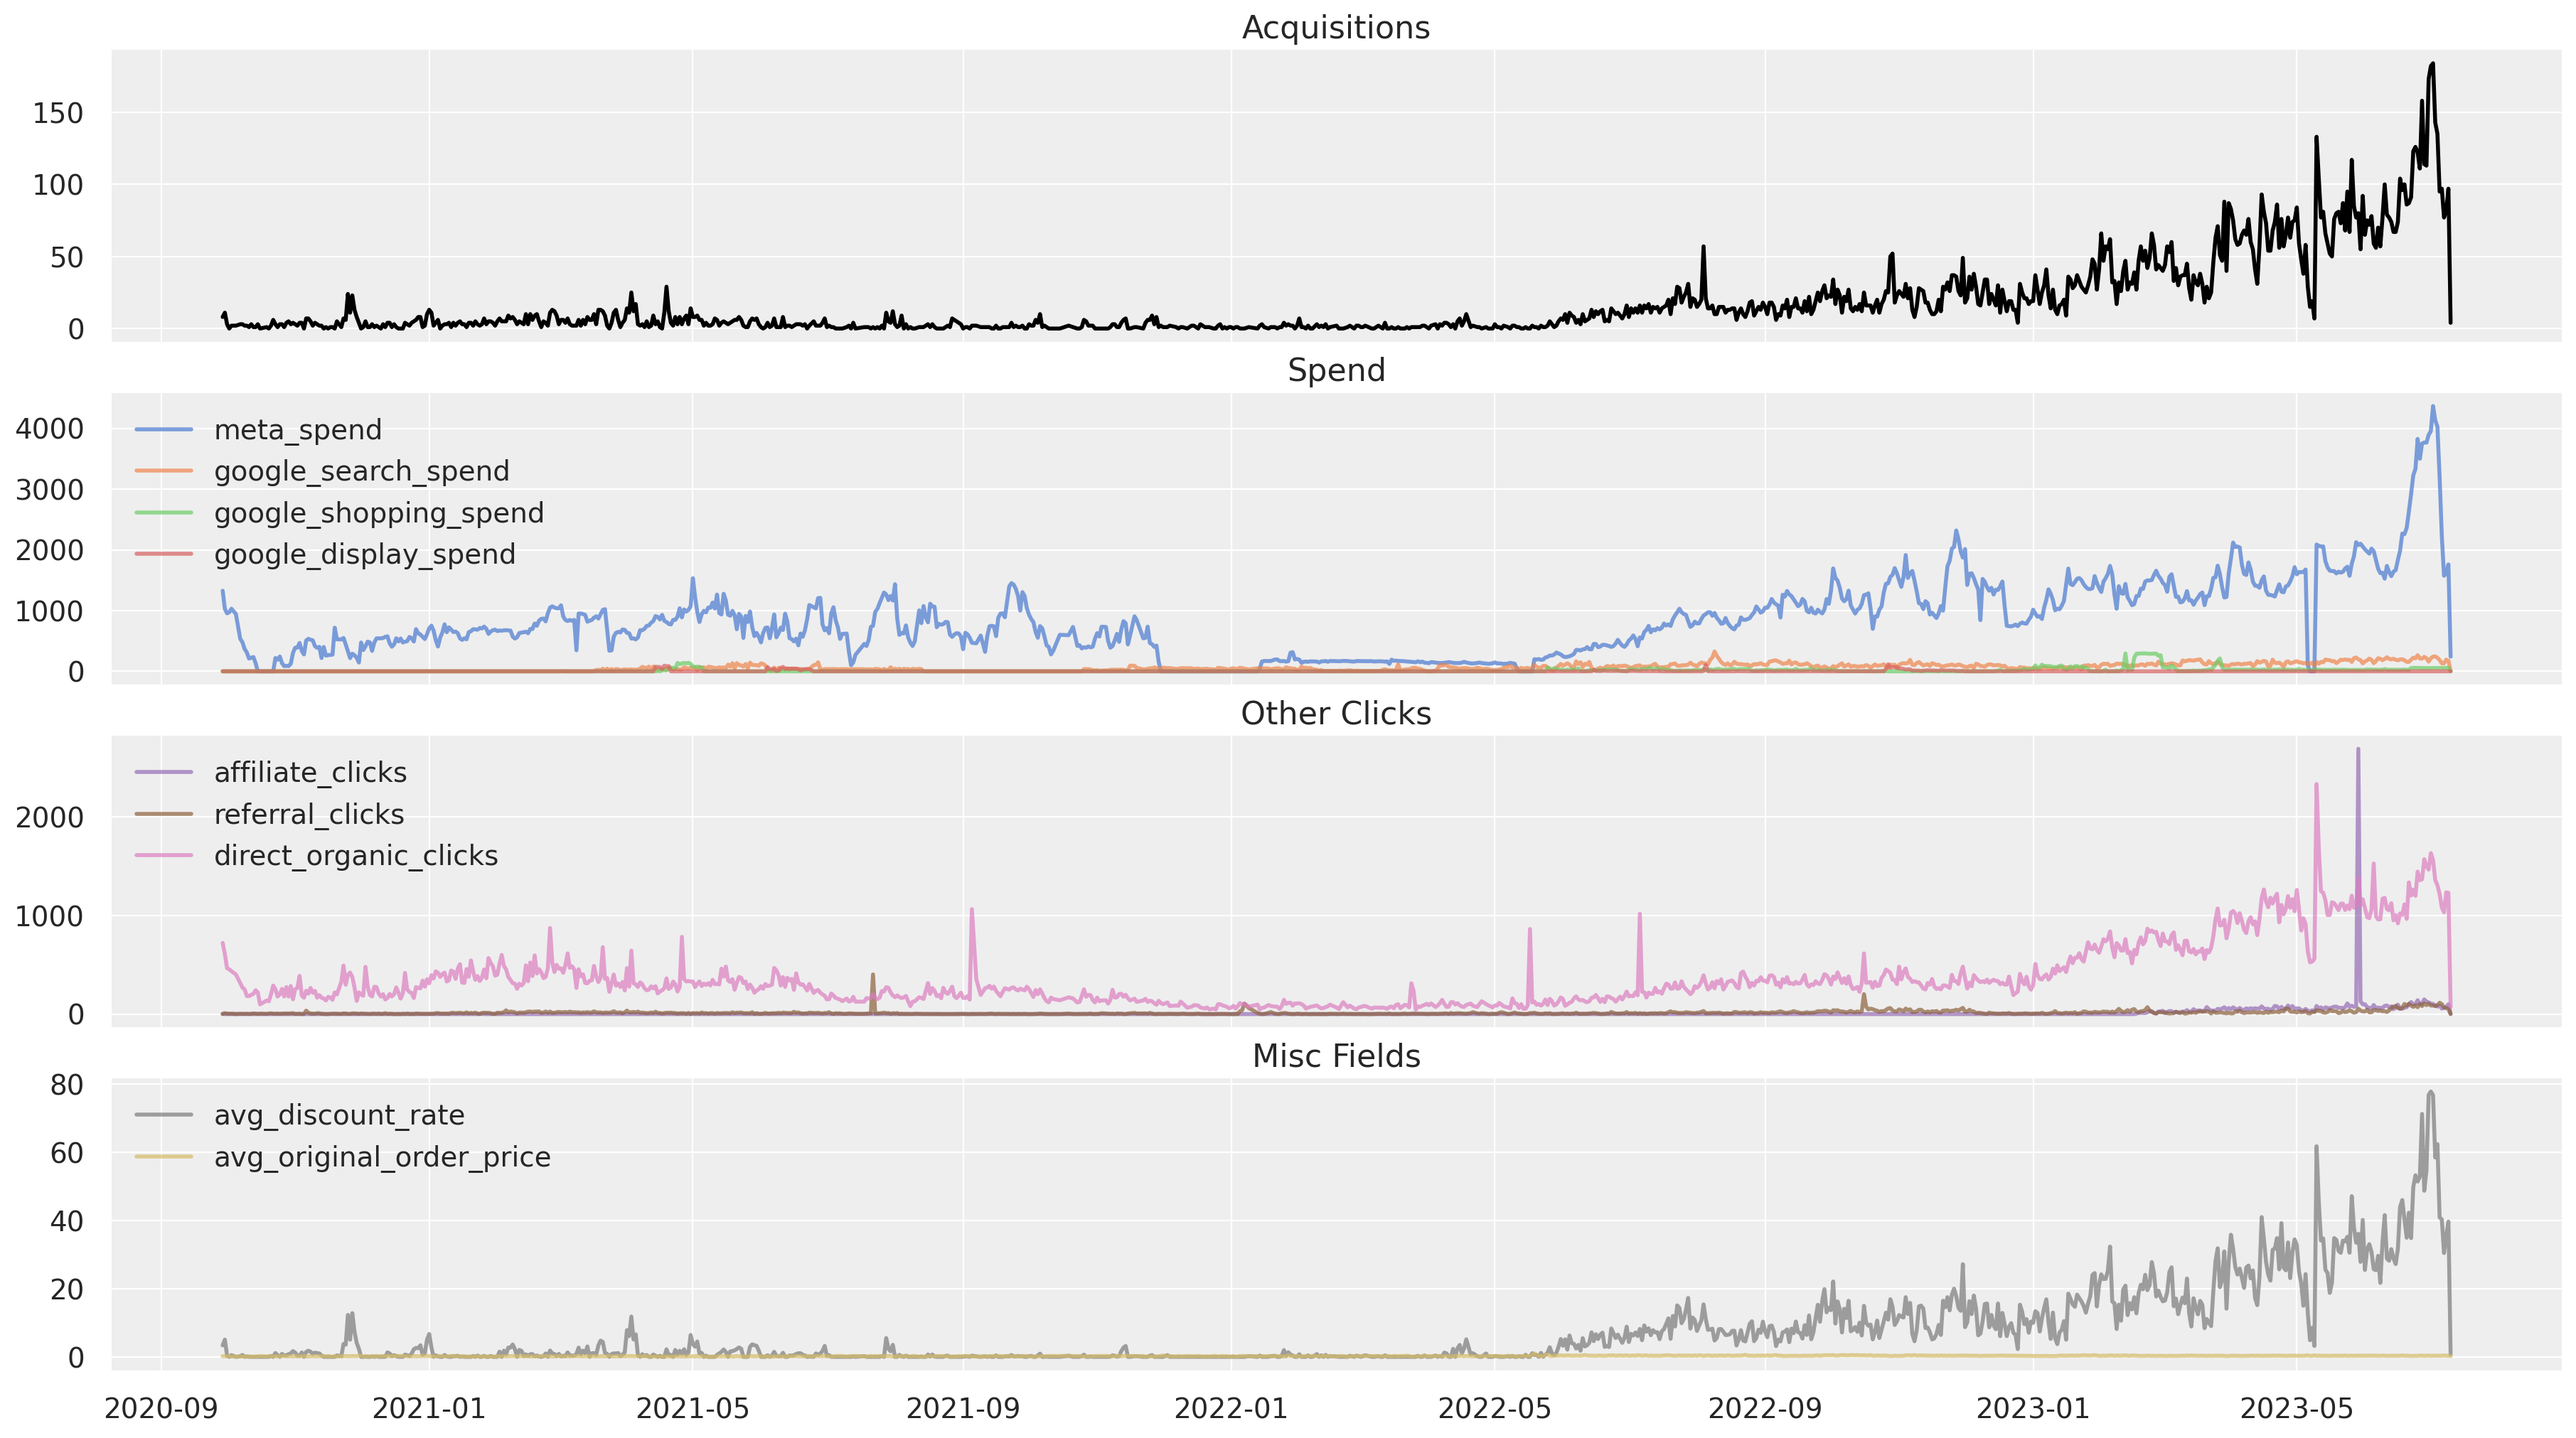

In [19]:
data = build_regression_data_from_benchmark_org(org_id=org_id, grain='daily')

# only use channels with spend
channel_columns = data.filter(like='_spend').sum(axis=0)
channel_columns = list(channel_columns[channel_columns > 0].index)

# derived columns (possible controls)
data['direct_organic_clicks'] = data.direct_clicks + data.organic_search_clicks + data.branded_search_clicks
data['avg_original_unit_price'] = data.acquisition_original_price / data.acquisition_orders_units
data['avg_original_unit_price'] = SimpleImputer(strategy='mean').fit_transform(data.avg_original_unit_price.values.reshape(-1,1))
data['avg_original_order_price'] = data.acquisition_original_price / data.acquisitions
data['avg_original_order_price'] = SimpleImputer(strategy='mean').fit_transform(data.avg_original_order_price.values.reshape(-1,1))
data['avg_discount_rate'] = -data.acquisition_orders_discount / data.avg_original_order_price
data['avg_discount_rate'] = SimpleImputer(strategy='median').fit_transform(data.avg_discount_rate.values.reshape(-1,1))
data['avg_original_order_price'] = data.avg_original_order_price / data.avg_original_order_price.max()
traffic_columns = ['affiliate_clicks', 'referral_clicks', 'direct_organic_clicks']
extra_columns = ['avg_discount_rate', 'avg_original_order_price']

fig, ax = plt.subplots(4, 1, figsize=(18,10), sharex=True)
colors = sns.color_palette("muted", n_colors=20)

n = 0
ax[0].plot(data.day_date, data.acquisitions, color='black', linewidth=2)
ax[0].set_title('Acquisitions')
sns.despine(ax=ax[1], offset=10)
for c in channel_columns:
    ax[1].plot(data.day_date, data[c], color=colors[n], linewidth=2, alpha=0.7, label=c)
    n += 1
ax[1].set_title('Spend')
sns.despine(ax=ax[0], offset=10)
ax[1].legend()
for c in traffic_columns:
    ax[2].plot(data.day_date, data[c], color=colors[n], linewidth=2, alpha=0.7,  label=c)
    n += 1
ax[2].set_title('Other Clicks')
sns.despine(ax=ax[2], offset=10)
ax[2].legend()
for c in extra_columns:
    ax[3].plot(data.day_date, data[c], color=colors[n], linewidth=2, alpha=0.7,  label=c)
    n += 1
ax[3].set_title('Misc Fields')
sns.despine(ax=ax[3], offset=10)
ax[3].legend()

#### Run the experimental matrix

Experiments are specified in an `experiments.yml` file which specifies the model variants. For each trial of the experiment, the model is saved to file to keep memory freed up. See the `ModelBuilder` base class for saving/loading models to disk. Just make sure to keep the results out of source control (tip: use `../local_dev/.` which is ignored by Git).

Example `experiments.yml`:
```
    sampling:
      draws: 5000
      chains: 4
    orgs:
      - '7f506b20-b11a-4ea6-8990-9377be9fc709'
      - '8ab8ce46-6577-43a8-aad9-6ed8564a80e2'
      - '13f9b442-efc7-4e8b-a755-3c3c2a6a0329'
      - '6b9e602a-11f0-4274-8cf6-2fcfbcc7a3ea'
      - '2752d3dc-1113-4ae9-8554-942d00dc6c96'
      - '982b5e06-ec5e-43b4-9ec1-8b68112aeec5'
      - '70bcb81a-f724-4f5c-bf1a-fdfdf4b9b906'
      - 'd284c60c-3b26-461a-bf60-5b1d5dc1e944'
    data_likelihoods:
      - 'normal'
      - 'student_t'
    grains:
      - 'daily'
      - 'weekly'
    channel_transforms:
      - 'no_transforms'
      - 'adstock_only'
      - 'adstock_saturated'
    controls:
      - 'no_controls'
      - 'direct_organic_clicks'
      - 'direct_organic_clicks,avg_original_unit_price,avg_discount_rate'
    yearly_seasonality:
      - 0
      - 2
      - 4
```

In [3]:
EXPERIMENTS_BASE_PATH = '../local-dev/experiments'

In [5]:
with open(f'{EXPERIMENTS_BASE_PATH}/experiments.yml', 'r') as f:
    experiments = yaml.safe_load(f)

draws = experiments.get('sampling').get('draws', 5000)
chains = experiments.get('sampling').get('chains', 4)
orgs = experiments.get('orgs', [])
grains = experiments.get('grains', ['daily'])
trials = list(itertools.product(
    experiments.get('data_likelihoods', ['normal']),
    experiments.get('channel_transforms', ['adstock_only']),
    experiments.get('controls', None),
    experiments.get('yearly_seasonality', [0])
))

In [11]:
for org_id, grain in itertools.product(orgs, grains):
    org_experiments_path = f'{EXPERIMENTS_BASE_PATH}/{org_id}'
    if not os.path.exists(org_experiments_path):
        os.makedirs(org_experiments_path)

    print(f'grain: {grain}, organisation: {org_id}')
    date_field, adstock_lmax = ('week_date', 4) if (grain == 'weekly') else ('day_date', 4*7)

    # prepare regression data
    data = build_regression_data_from_benchmark_org(org_id=org_id, grain=grain)
    data = data[data[date_field] <= pd.to_datetime('2023-06-30')] # looks like acquision data is getting dropped from 1-July, GA4?
    data['direct_organic_clicks'] = data.direct_clicks + data.organic_search_clicks + data.branded_search_clicks
    data['avg_original_unit_price'] = data.acquisition_original_price / data.acquisition_orders_units
    data['avg_original_unit_price'] = SimpleImputer(strategy='mean').fit_transform(data.avg_original_unit_price.values.reshape(-1,1))
    data['avg_original_order_price'] = data.acquisition_original_price / data.acquisitions
    data['avg_original_order_price'] = SimpleImputer(strategy='mean').fit_transform(data.avg_original_order_price.values.reshape(-1,1))
    data['avg_discount_rate'] = -data.acquisition_orders_discount / data.avg_original_order_price
    data['avg_discount_rate'] = SimpleImputer(strategy='median').fit_transform(data.avg_discount_rate.values.reshape(-1,1))

    # only use channels with spend
    channel_columns = data.filter(like='_spend').sum(axis=0)
    channel_columns = list(channel_columns[channel_columns > 0].index)
    print(f'using channels: {channel_columns}')

    for data_likelihood, channel_transforms, controls, yearly_seasonality in trials:
        trial = '::'.join([grain, data_likelihood, channel_transforms, controls, str(yearly_seasonality)])

        print(f'RAM userd: {psutil.virtual_memory()[2]}%,  {psutil.virtual_memory()[3]/1000000000}GB')
        print(f'starting trial: {trial}\n')

        mmm = MyMMM(
            date_column=date_field,
            channel_columns=channel_columns,
            control_columns=None if (controls is None or controls == 'no_controls') else controls.split(','),
            yearly_seasonality=None if yearly_seasonality == 0 else yearly_seasonality,
            channel_transforms=channel_transforms,
            adstock_max_lag=adstock_lmax,
            data_likelihood=data_likelihood,
            sampler_config={'draws':draws, 'chains':chains}
        )
        # include log-likelihood for model comparison
        mmm.fit(X=data.drop(columns='acquisitions'), y=data.acquisitions, random_seed=rng, idata_kwargs={"log_likelihood": True})

        # save fit model
        trial_file = f'{org_experiments_path}/{trial}.nc'
        mmm.save(trial_file)

grain: daily, organisation: 7f506b20-b11a-4ea6-8990-9377be9fc709
using channels: ['meta_spend', 'google_search_spend', 'google_shopping_spend', 'google_display_spend']
RAM userd: 23.0%,  3.180883968GB
starting trial: daily::student_t::no_transforms::no_controls::0



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, beta_channel, sigma, nu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 50 seconds.


### Model Validation

In [10]:
from pathlib import Path

def reload_model_from_file(fname: str) -> MyMMM:
    """
    pass the file name and return an instance of MyMMM
    """
    filepath = Path(str(fname))
    idata = az.from_netcdf(filepath)
    model = MyMMM(
        date_column=json.loads(idata.attrs["date_column"]),
        channel_columns=json.loads(idata.attrs["channel_columns"]),
        control_columns=json.loads(idata.attrs["control_columns"]),
        yearly_seasonality=json.loads(idata.attrs["yearly_seasonality"]),
        channel_transforms=json.loads(idata.attrs["channel_transforms"]),
        adstock_max_lag=json.loads(idata.attrs["adstock_max_lag"]),
        data_likelihood=json.loads(idata.attrs["data_likelihood"]),
        sampler_config=json.loads(idata.attrs["sampler_config"])
    )
    model.idata = idata
    data = idata.fit_data.to_dataframe()
    X = data.drop(columns=[model.output_var])
    y = data[model.output_var]
    model._generate_and_preprocess_model_data(X, y.values)
    model.build_model(X, y)

    if model.id != idata.attrs["id"]:
        raise ValueError(
            f"The file '{fname}' does not contain an inference data of the same model or configuration as '{model._model_type}'"
        )
    return model

In [6]:
org_id = '2752d3dc-1113-4ae9-8554-942d00dc6c96'
trials_path = f'{EXPERIMENTS_BASE_PATH}/{org_id}'

model evalation based on:
- MCMC convergence using a combination of `r_hat` and `ess`.
- HMC divergences (these are allowable, but should be a small percentage of total draws)
- leave-one-out expected log predictive density (LOO ELPD) based on Pareto-weighted importance sampling of the trace to mimimise retraining. NB: LOO is probably overly optimistic for time series and we really [should use LFO](https://github.com/arviz-devs/arviz/issues/2068).

In [ ]:
from collections import defaultdict

diagnostics = defaultdict(list)
for trial in os.listdir(trials_path):
    model = reload_model_from_file(f'{trials_path}/{trial}')
    # flag convergence issues for key parameters
    vars = []
    for v in model.idata.posterior.data_vars:
        if "date" not in model.idata.posterior.data_vars[v].coords:
            vars.append(v)
    df = az.summary(model.idata, var_names=vars)
    convergence_issues = 0
    convergence_issues += (df.r_hat > 1.05).sum()
    convergence_issues += (df.ess_bulk / (model.sampler_config['draws'] * model.sampler_config["chains"]) < 0.1).sum()
    # estimate out-of-sample fit (https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/model_comparison.html)
    loo = az.loo(model.idata)
    waic = az.waic(model.idata)
    # record diagnostics
    diagnostics['trial'].append(trial)
    diagnostics['convergence_issues'].append(convergence_issues > 0)
    diagnostics['divergences'].append(model.idata.sample_stats.data_vars["diverging"].data.sum())
    diagnostics['loo'].append(loo.elpd_loo)
    diagnostics['loo_se'].append(loo.se)
    diagnostics['waic'].append(waic.elpd_waic)
    diagnostics['waic_se'].append(waic.se)

# unpack trial variants
expt_cols = {
    0:'time_grain',
    1:'likelihood',
    2:'channel_transform',
    3:'controls',
    4:'fourier_modes'
}
diagnostics = pd.DataFrame(diagnostics)
diagnostics = pd.concat([diagnostics, diagnostics.trial.str.replace('.nc','').str.split('::', expand=True).rename(columns=expt_cols)], axis=1)

/opt/conda/envs/mmm/lib/python3.11/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/opt/conda/envs/mmm/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/conda/envs/mmm/lib/python3.11/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/opt/conda/envs/mmm/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/conda/envs/mmm/lib/python3.11/site-packages/arviz/data/in

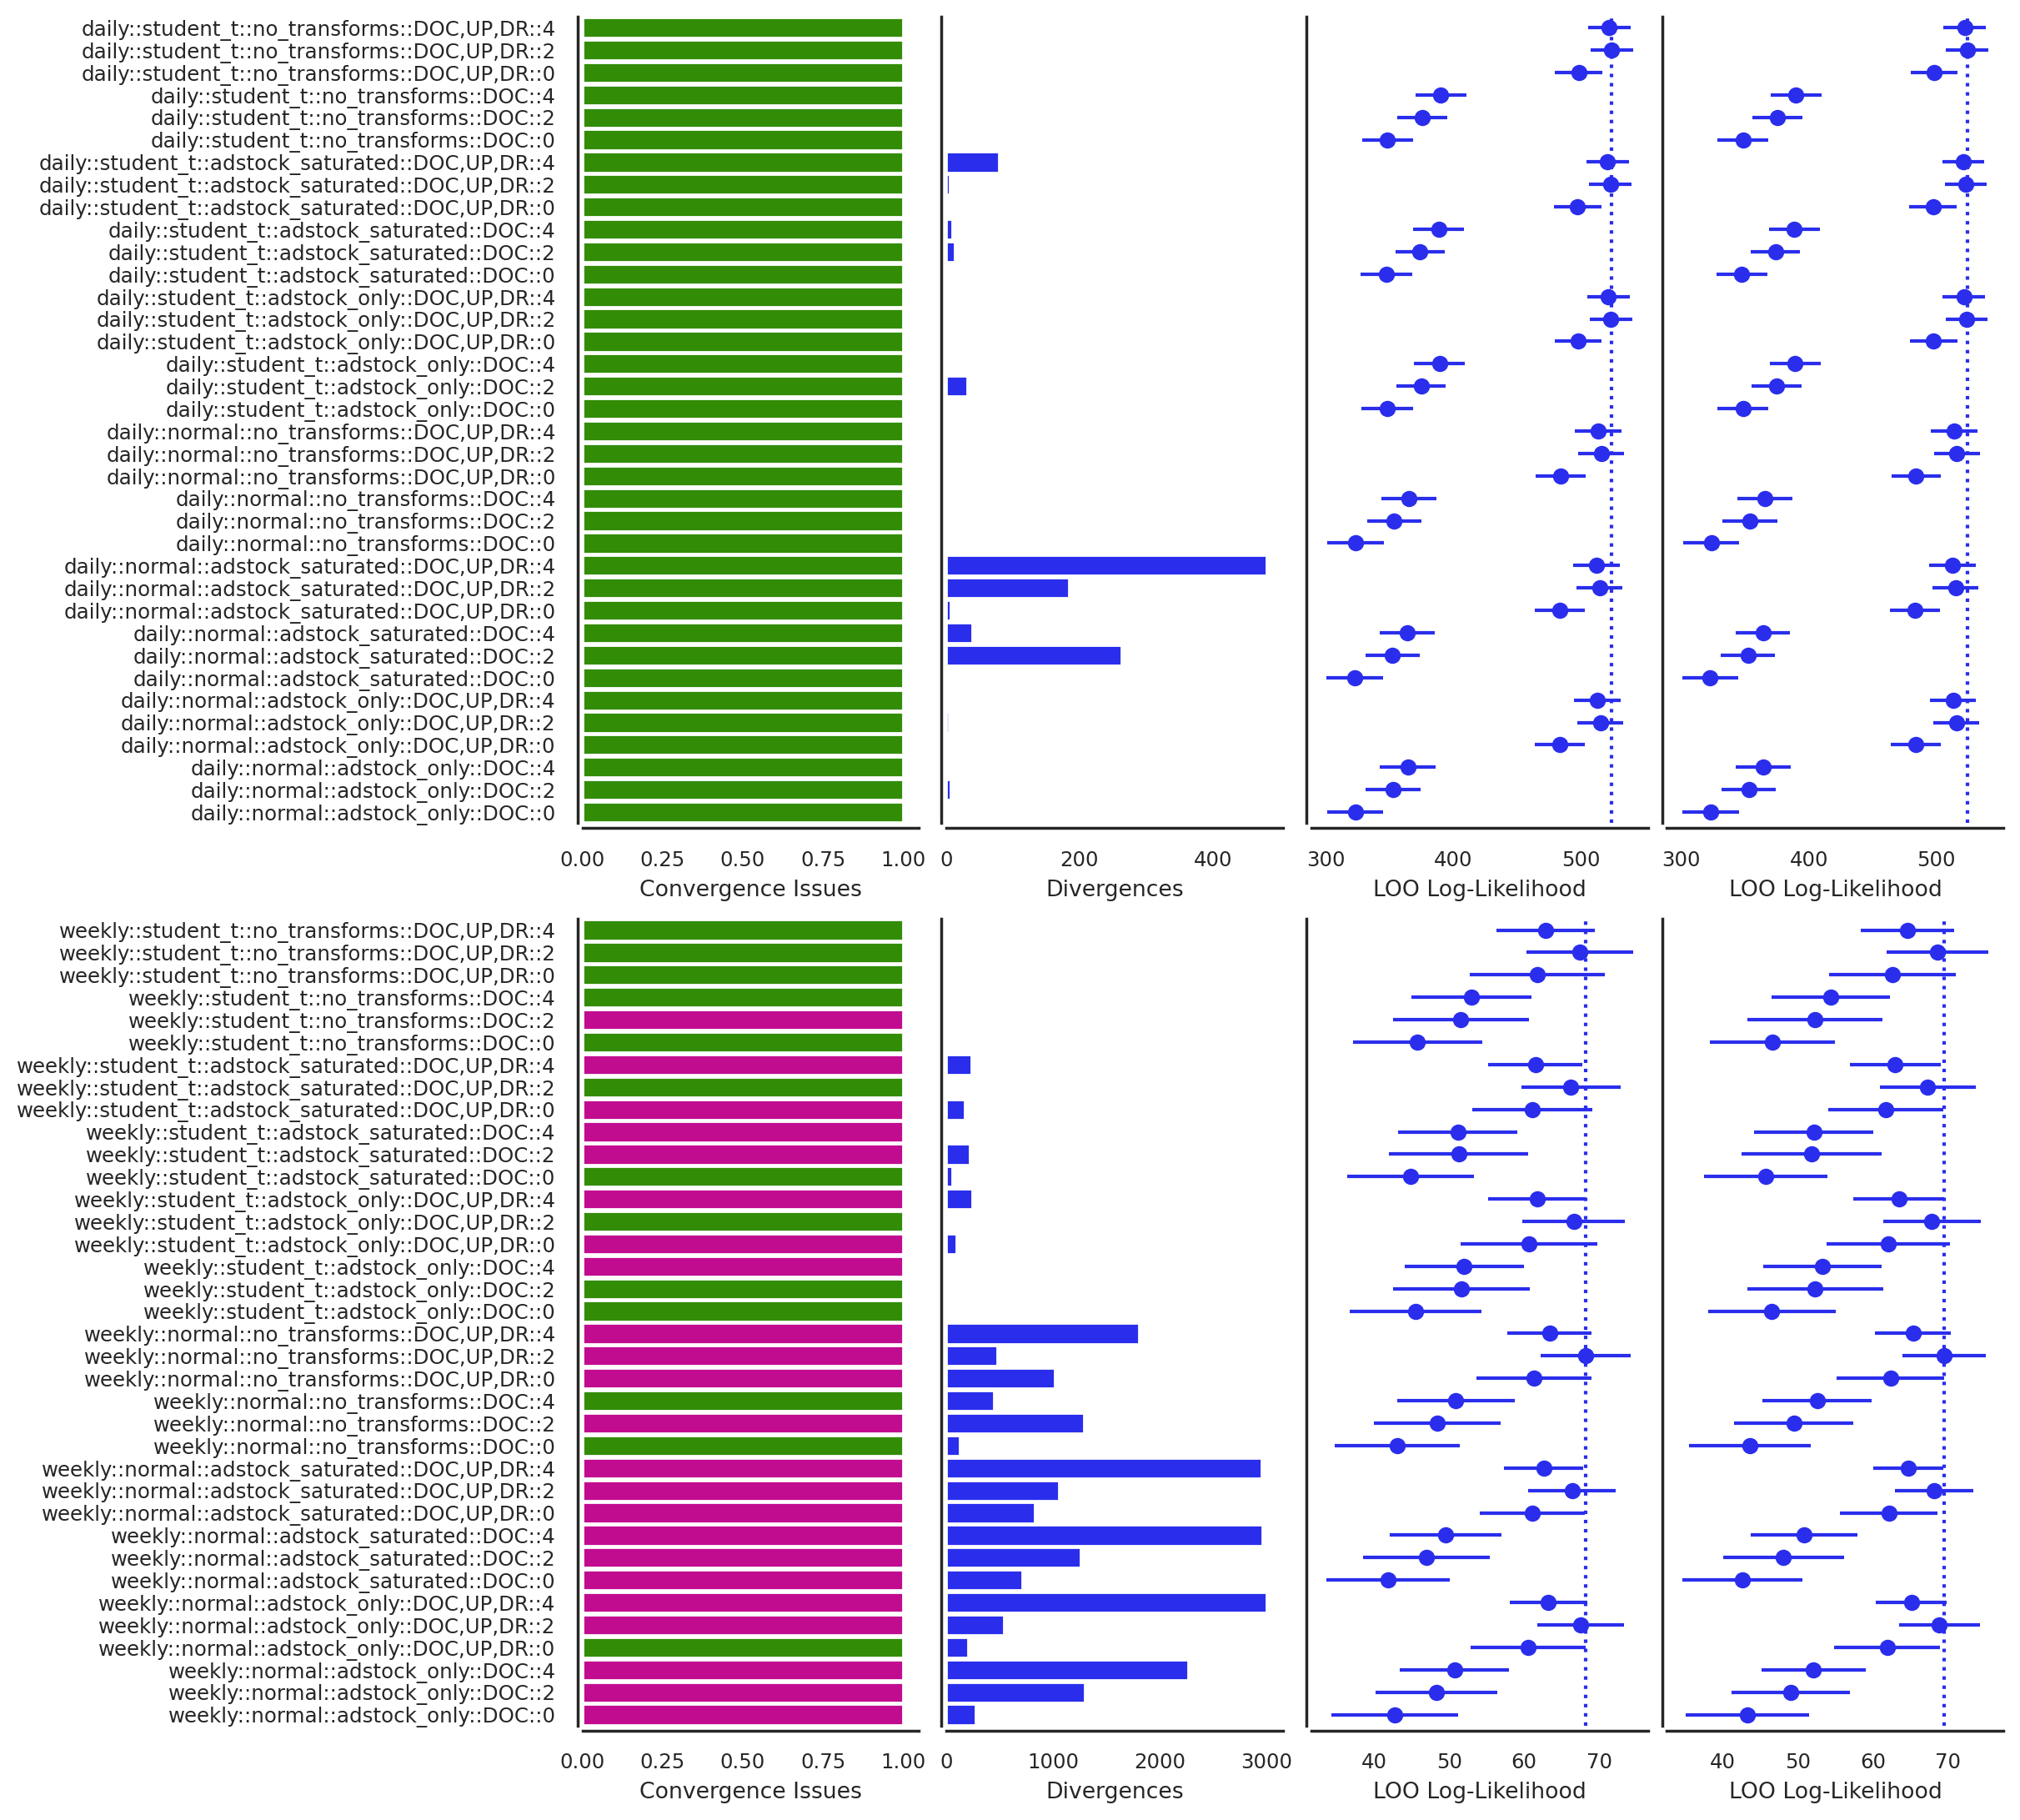

In [ ]:
import seaborn as sns

sns.set_context('notebook', font_scale=0.8)
sns.set_style('white')

df_plt = diagnostics.copy()
df_plt['trial'] = (
    df_plt
    .trial
    .str.replace('direct_organic_clicks','DOC')
    .str.replace('avg_original_unit_price','UP')
    .str.replace('avg_discount_rate','DR')
    .str.replace('.nc', '')
)
df_plt = df_plt.set_index(list(expt_cols.values())).sort_index()

fig, ax = plt.subplots(2, 4, sharey='row', figsize=(12, 0.15*len(df_plt)))

for i, grain in enumerate(['daily', 'weekly']):
    h = 1 / len(df_plt.loc[pd.IndexSlice[grain,:,:,:,:],:])
    y = np.arange(0, 1, h) + h/2
    ax[i,0].barh(y=y, width=1, height=0.9*h, color=['#c10c90' if c else '#328c06' for c in df_plt.loc[pd.IndexSlice[grain,:,:,:,:], 'convergence_issues']])
    ax[i,0].set_xlabel('Convergence Issues')
    ax[i,1].barh(y=y, width=df_plt.loc[pd.IndexSlice[grain,:,:,:,:], 'divergences'], height=0.9*h)
    ax[i,1].set_xlabel('Divergences')
    # ax[i,2].barh(y=y, width=df_plt.loc[pd.IndexSlice[grain,:,:,:,:], 'loo'], height=0.9*h)
    ax[i,2].errorbar(x=df_plt.loc[pd.IndexSlice[grain,:,:,:,:], 'loo'], y=y, xerr=df_plt.loc[pd.IndexSlice[grain,:,:,:,:], 'loo_se'], fmt='o')
    ax[i,2].vlines(x=df_plt.loc[pd.IndexSlice[grain,:,:,:,:], 'loo'].max(), ymin=0, ymax=1, linestyle='dotted')
    ax[i,2].set_xlabel('LOO Log-Likelihood')
    # ax[i,3].barh(y=y, width=df_plt.loc[pd.IndexSlice[grain,:,:,:,:], 'waic'], height=0.9*h)
    ax[i,3].errorbar(x=df_plt.loc[pd.IndexSlice[grain,:,:,:,:], 'waic'], y=y, xerr=df_plt.loc[pd.IndexSlice[grain,:,:,:,:], 'waic_se'], fmt='o')
    ax[i,3].vlines(x=df_plt.loc[pd.IndexSlice[grain,:,:,:,:], 'waic'].max(), ymin=0, ymax=1, linestyle='dotted')
    ax[i,3].set_xlabel('LOO Log-Likelihood')
    ax[i,0].set_yticks(y, df_plt.loc[pd.IndexSlice[grain,:,:,:,:], 'trial'].replace(f'{grain}::',''))
    ax[i,0].set_ylim(0, 1)
    sns.despine(ax=ax[i,0], offset=2)
    sns.despine(ax=ax[i,1], offset=2)
    sns.despine(ax=ax[i,2], offset=2)
    sns.despine(ax=ax[i,3], offset=2)

Examine prior and posterior predictive plots for chosen trials. Does this model pass the eyeball test?

In [ ]:
trials = [
    'weekly::student_t::adstock_saturated::direct_organic_clicks,avg_original_unit_price,avg_discount_rate::4',
    'daily::student_t::adstock_saturated::direct_organic_clicks,avg_original_unit_price,avg_discount_rate::4',
]

for trial in trials:
    print(trial)
    model = reload_model_from_file(f'{trials_path}/{trial}.nc')
    model.plot_prior_predictive(figsize=(14,7)).show()
    model.plot_posterior_predictive(figsize=(14,7)).show()

weekly::student_t::adstock_saturated::direct_organic_clicks,avg_original_unit_price,avg_discount_rate::4


NameError: name 'reload_model_from_file' is not defined

Compare mean CAC predictions across all trials. This could be improved with confidence intervals using HDI.

In [11]:
contributions = defaultdict(list)
for trial in os.listdir(trials_path):
    model = reload_model_from_file(f'{trials_path}/{trial}')
    # extract channel contributions in original scale and compute cac
    cac = (
        az
        .extract(model.fit_result, var_names=["channel_contributions"], combined=False)
        .mean(["chain","draw"])
        .to_dataframe()
        .squeeze()
        .unstack()
    )
    cac = pd.DataFrame(model.get_target_transformer().inverse_transform(cac), columns=cac.columns, index=cac.index)
    cac = model.idata.fit_data.to_dataframe()[cac.columns].sum().divide(cac.sum())
    # record trial
    contributions['trial'].append(trial)
    for c in cac.index:
        contributions[f'{c.replace("_spend","")}'].append(cac[c])

# unpack trial variants
expt_cols = {
    0:'time_grain',
    1:'likelihood',
    2:'channel_transform',
    3:'controls',
    4:'fourier_modes'
}
contributions = pd.DataFrame(contributions)
contributions = pd.concat([contributions, contributions.trial.str.replace('.nc','').str.split('::', expand=True).rename(columns=expt_cols)], axis=1)

/opt/conda/envs/mmm/lib/python3.11/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/opt/conda/envs/mmm/lib/python3.11/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/opt/conda/envs/mmm/lib/python3.11/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/opt/conda/envs/mmm/lib/python3.11/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/opt/conda/envs/mmm/lib/python3.11/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/opt/conda/envs/mmm/lib/python3.11/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceDat

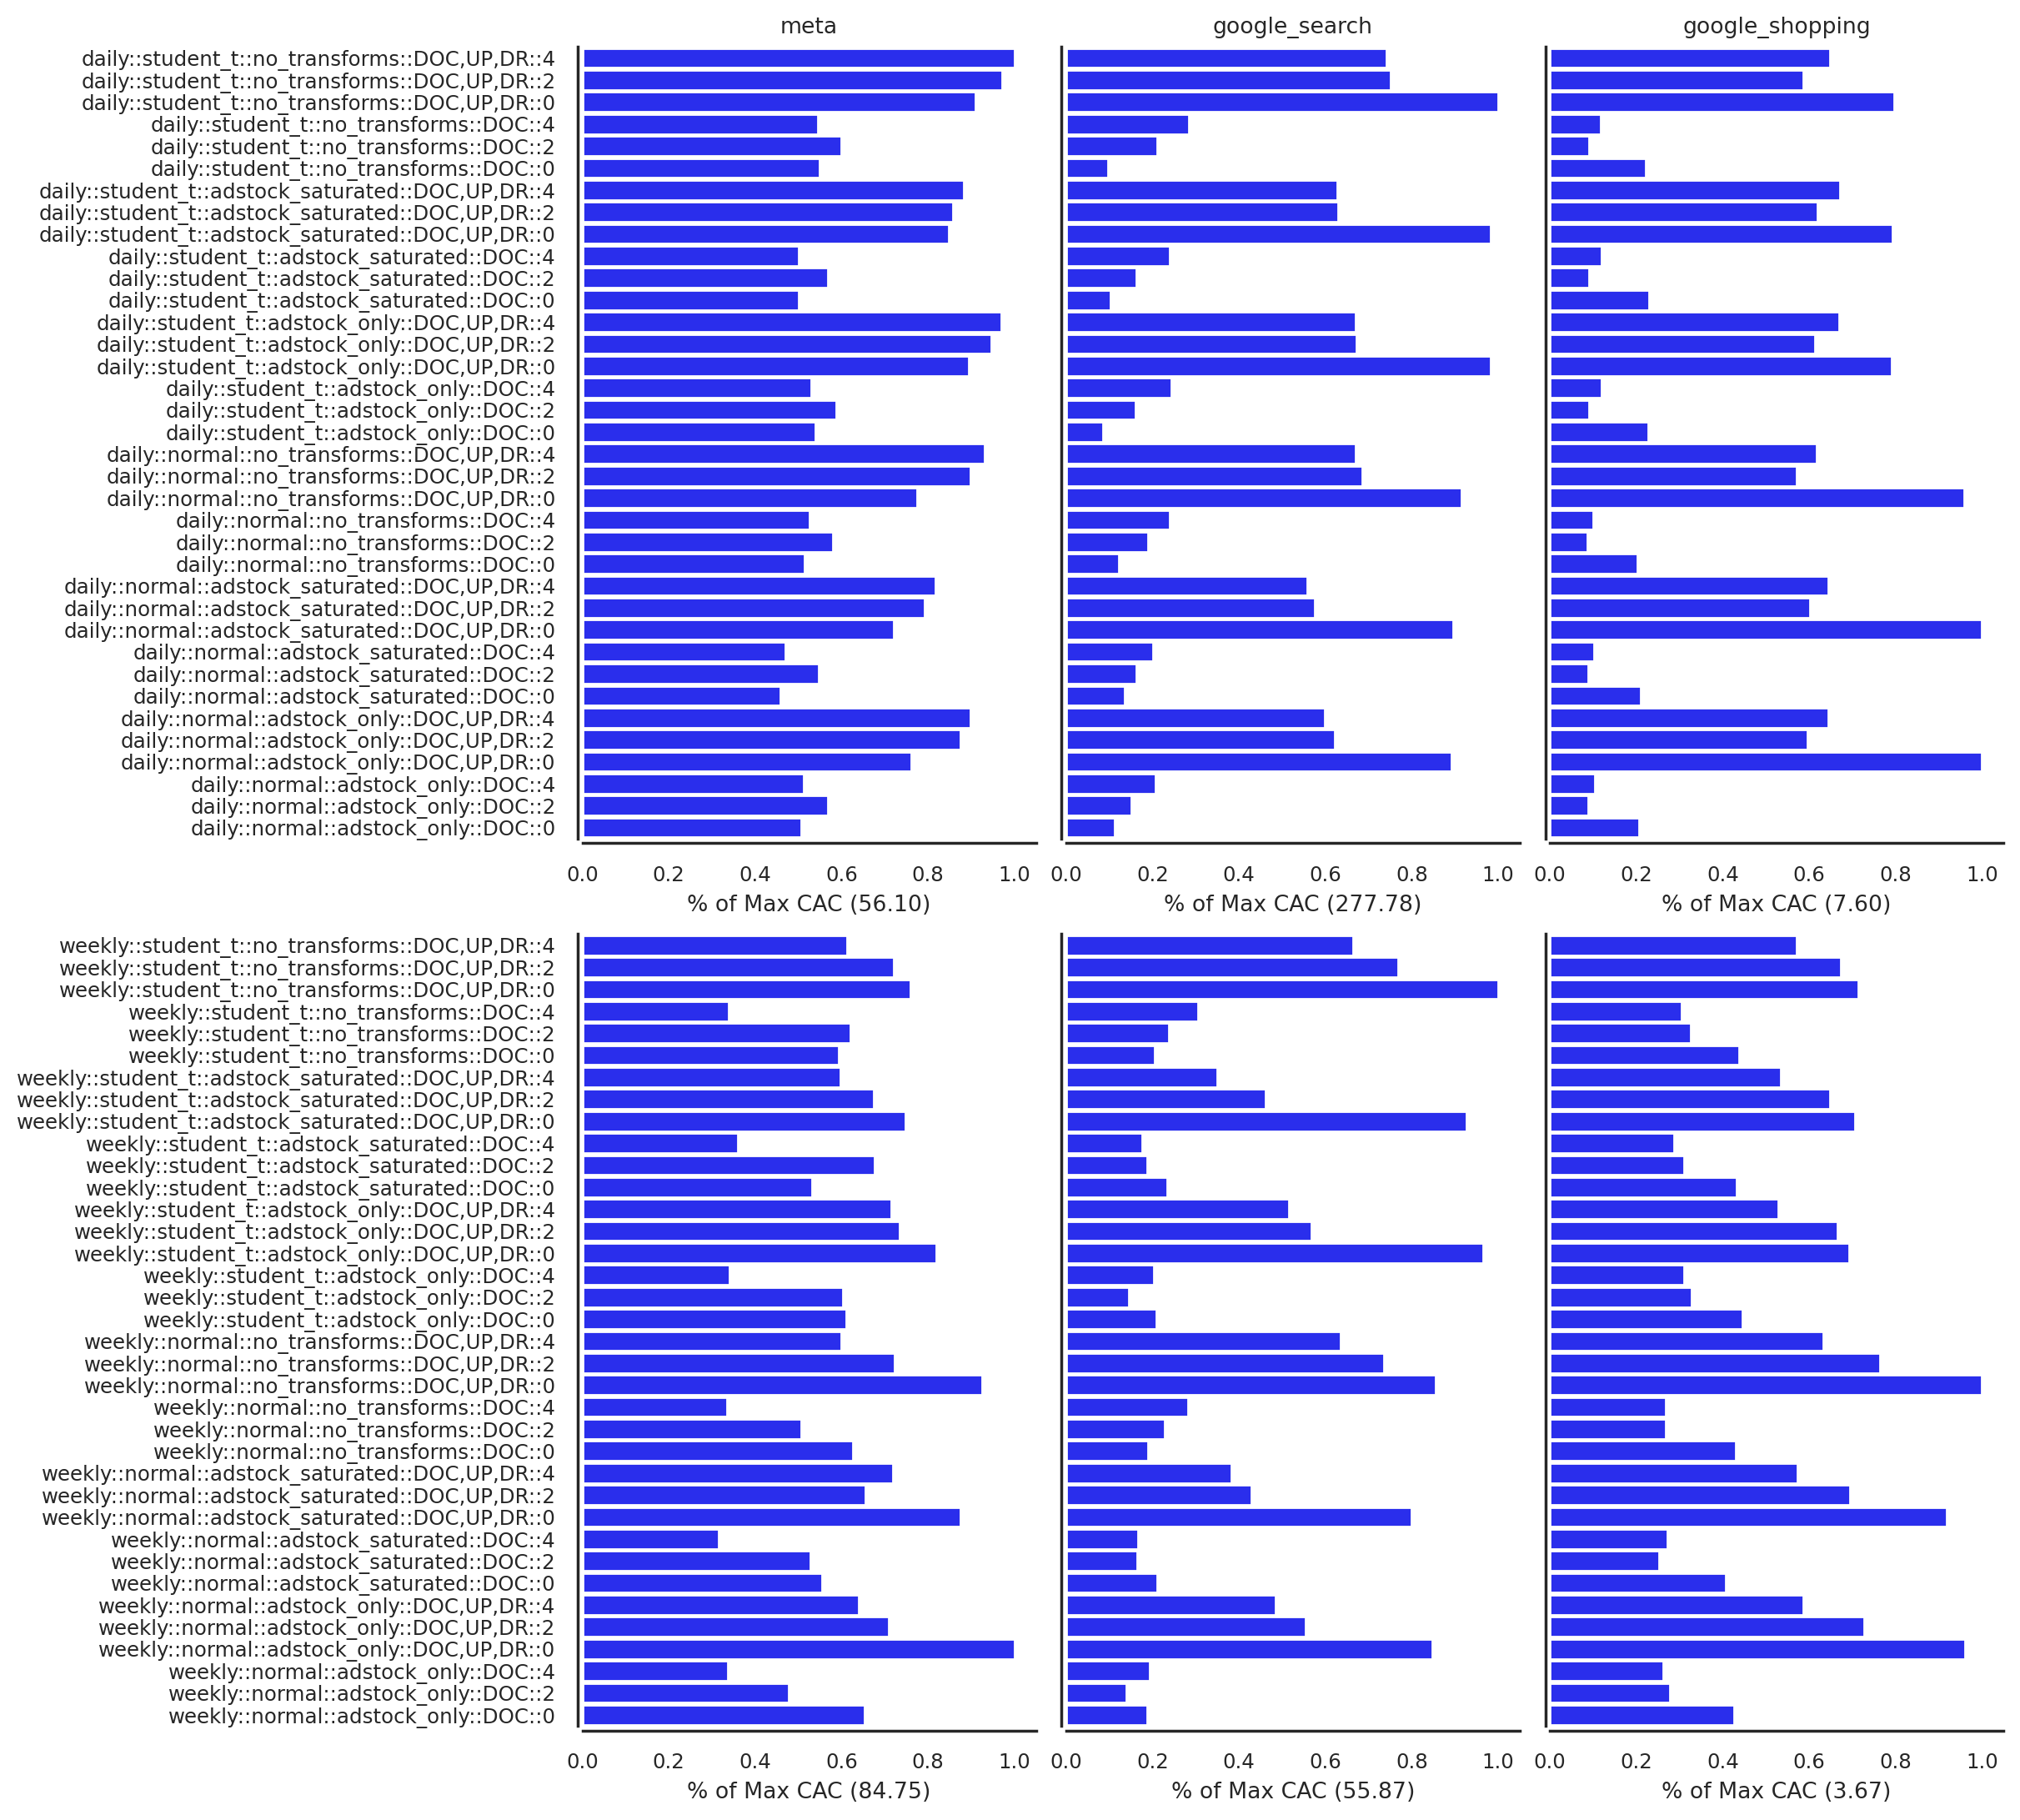

In [12]:
df_plt = contributions.copy()
df_plt['trial'] = (
    df_plt
    .trial
    .str.replace('direct_organic_clicks','DOC')
    .str.replace('avg_original_unit_price','UP')
    .str.replace('avg_discount_rate','DR')
    .str.replace('.nc', '')
)
df_plt = df_plt.set_index(list(expt_cols.values())).sort_index()

fig, ax = plt.subplots(2, len(df_plt.columns)-1, sharey='row', figsize=(12, 0.15*len(df_plt)))

for i, grain in enumerate(['daily', 'weekly']):
    h = 1 / len(df_plt.loc[pd.IndexSlice[grain,:,:,:,:],:])
    y = np.arange(0, 1, h) + h/2
    for j, c in enumerate([c for c in df_plt.columns if c != 'trial']): 
        cac_max = df_plt.loc[pd.IndexSlice[grain,:,:,:,:], c].max()
        width = df_plt.loc[pd.IndexSlice[grain,:,:,:,:], c] / cac_max
        ax[i,j].barh(y=y, width=width, height=0.9*h)
        ax[i,j].set_xlabel(f'% of Max CAC ({cac_max:.2f})')
        if i == 0:
            ax[i,j].set_title(c)
        if j == 0:
            ax[i,j].set_yticks(y, df_plt.loc[pd.IndexSlice[grain,:,:,:,:], 'trial'].replace(f'{grain}::',''))
            ax[i,j].set_ylim(0, 1)    
        sns.despine(ax=ax[i,j], offset=2)